In [ ]:
# Importing our data from the cloud and viewing and understanding it.
!wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded

--2021-06-20 06:02:42--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2021-06-20 06:02:43--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.45.26
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.45.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1.2G) [applicatio

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-20 06:03:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-20 06:03:40 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Importing dependancies
import zipfile
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("file_downloaded")
zip_ref.extractall()
zip_ref.close()

In [ ]:
data_dir = pathlib.Path("/content/chest_xray/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names = class_names[1:]
print(class_names)

['NORMAL' 'PNEUMONIA']


In [ ]:
walk_through_dir("101_food_classes_10_percent")

In [ ]:
# setup data inputs
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/chest_xray/train/"
test_dir = "/content/chest_xray/test/"

print("Train images :")
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMAGE_SHAPE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

print("Testing images :")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SHAPE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)

Train images :
Found 5232 files belonging to 2 classes.
Testing images :
Found 624 files belonging to 2 classes.


In [ ]:
# See an example batch of data
for images, labels in train_data.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.02178574e+02 1.02178574e+02 1.02178574e+02]
   [9.23214264e+01 9.23214264e+01 9.23214264e+01]
   [8.98214264e+01 8.98214264e+01 8.98214264e+01]
   ...
   [7.93214264e+01 7.93214264e+01 7.93214264e+01]
   [8.78571396e+01 8.78571396e+01 8.78571396e+01]
   [1.03285713e+02 1.03285713e+02 1.03285713e+02]]

  [[9.36250000e+01 9.36250000e+01 9.36250000e+01]
   [9.00357132e+01 9.00357132e+01 9.00357132e+01]
   [9.50535736e+01 9.50535736e+01 9.50535736e+01]
   ...
   [6.95357132e+01 6.95357132e+01 6.95357132e+01]
   [8.28571472e+01 8.28571472e+01 8.28571472e+01]
   [8.70357132e+01 8.70357132e+01 8.70357132e+01]]

  [[9.49285736e+01 9.49285736e+01 9.49285736e+01]
   [8.36071396e+01 8.36071396e+01 8.36071396e+01]
   [9.53035736e+01 9.53035736e+01 9.53035736e+01]
   ...
   [7.96607132e+01 7.96607132e+01 7.96607132e+01]
   [9.16428528e+01 9.16428528e+01 9.16428528e+01]
   [9.83571472e+01 9.83571472e+01 9.83571472e+01]]

  ...

  [[1.27143555e+01 1.27143555e+01 1.27143555e+01]
   [2

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 1), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(2, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), 
                        callbacks=[create_tensorboard_callback("EfficientNetb0_1", "EfficientNetb0_1-Model_1")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: EfficientNetb0_1/EfficientNetb0_1-Model_1/20210620-060902
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


164/164 [==============================] - 74s 236ms/step - loss: 0.2490 - accuracy: 0.9048 - val_loss: 0.5378 - val_accuracy: 0.7437
Epoch 2/5
164/164 [==============================] - 39s 230ms/step - loss: 0.1387 - accuracy: 0.9516 - val_loss: 0.4662 - val_accuracy: 0.7688
Epoch 3/5
164/164 [==============================] - 38s 225ms/step - loss: 0.1181 - accuracy: 0.9555 - val_loss: 0.4569 - val_accuracy: 0.8062
Epoch 4/5
164/164 [==============================] - 38s 224ms/step - loss: 0.1063 - accuracy: 0.9625 - val_loss: 0.5198 - val_accuracy: 0.8125
Epoch 5/5
164/164 [==============================] - 37s 222ms/step - loss: 0.0931 - accuracy: 0.9685 - val_loss: 0.6628 - val_accuracy: 0.7625


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

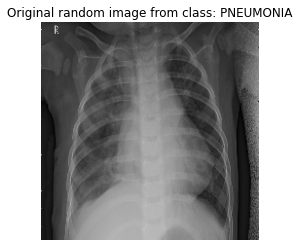

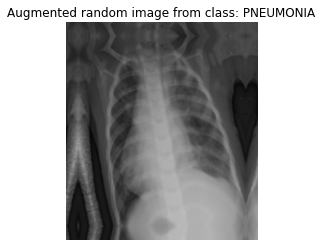

In [ ]:
target_class = random.choice(train_data.class_names) # choose a random class
target_dir = train_dir + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = tf.io.read_file(random_image_path) # read in the chosen target image
img = tf.image.decode_image(img)
img = tf.image.resize(img, size=IMAGE_SHAPE)
img = img/255
img = tf.image.grayscale_to_rgb(img)
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
# img = tf.image.grayscale_to_rgb(img)
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 1)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(2, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25* len(test_data)), 
                        callbacks=[create_tensorboard_callback("EfficientNetb0_2", "EfficientNetb0_2-Model_2")])

Saving TensorBoard log files to: EfficientNetb0_2/EfficientNetb0_2-Model_2/20210620-061927
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


164/164 [==============================] - 79s 446ms/step - loss: 0.3100 - accuracy: 0.8689 - val_loss: 0.3709 - val_accuracy: 0.8062
Epoch 2/5
164/164 [==============================] - 59s 355ms/step - loss: 0.1867 - accuracy: 0.9253 - val_loss: 0.3028 - val_accuracy: 0.9000
Epoch 3/5
164/164 [==============================] - 56s 335ms/step - loss: 0.1699 - accuracy: 0.9352 - val_loss: 0.2812 - val_accuracy: 0.9062
Epoch 4/5
164/164 [==============================] - 52s 309ms/step - loss: 0.1520 - accuracy: 0.9404 - val_loss: 0.2951 - val_accuracy: 0.8750
Epoch 5/5
164/164 [==============================] - 52s 311ms/step - loss: 0.1415 - accuracy: 0.9448 - val_loss: 0.3005 - val_accuracy: 0.8625


In [ ]:
model_1.evaluate(test_data)

20/20 [==============================] - 4s 138ms/step - loss: 0.3286 - accuracy: 0.8590


[0.3286426067352295, 0.8589743375778198]

In [ ]:
# function to import image and resize 
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape,, color_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image  
  img = tf.image.resize(img, size=IMAGE_SHAPE)
  #Grayscale
  print(f"Image before conv = {img}")
  if img.shape[2] == 1:
    img = tf.image.grayscale_to_rgb(img)
  print(f"Image after conv = {img}")
  # Rescale the image (getting all values between 0 & 1)
  # img = img/255

  return img

In [ ]:
def pred_and_plot(model, filename, class_names=["NORMAL","PNEUMONIA"]):
  """
  Imports an image located at filename, makes a prediction with model and plots the image with the predicted class as the title.
  """
  # Import target image and preprocess it 
  img = load_and_prep_image(filename)

  # Make a prediction 
  pred = model.predict(tf.expand_dims(img, axis=0))
  # pred = model.predict(tf.squeeze(img))
  print(f"Prediction is {tf.squeeze(pred).numpy()}")
  # print(f"Prediction is {pred}")

  # Get the predicted class 
  # pred_class = class_names[int(tf.round(pred))]
  pred_class = class_names[int(tf.argmax(tf.squeeze(pred).numpy()))]

  # Plot image and predicted class
  img = img/255
  plt.imshow(img)
  plt.title(f"Prediction : {pred_class}")
  plt.axis(False);

Image shape = (224, 224, 3)
Prediction is [0.40905583 0.5909442 ]


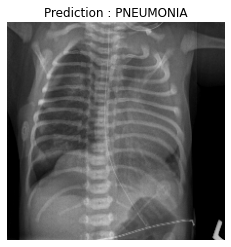

In [ ]:
pred_and_plot(model_1, "/content/pneu2.jpg")

In [ ]:
preds = model_1.predict(test_data)
preds

array([[0.8795361 , 0.12046391],
       [0.9842641 , 0.01573592],
       [0.86099774, 0.1390023 ],
       ...,
       [0.11971442, 0.8802856 ],
       [0.44137385, 0.5586261 ],
       [0.8298626 , 0.17013744]], dtype=float32)

In [ ]:
preds.shape

(624, 2)

In [ ]:
preds = preds.argmax(axis=1)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

624

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, preds)
sklearn_accuracy

0.8926282051282052

In [ ]:
y_labels = tf.expand_dims(y_labels, axis=1)
y_preds = tf.expand_dims(preds, axis=1)

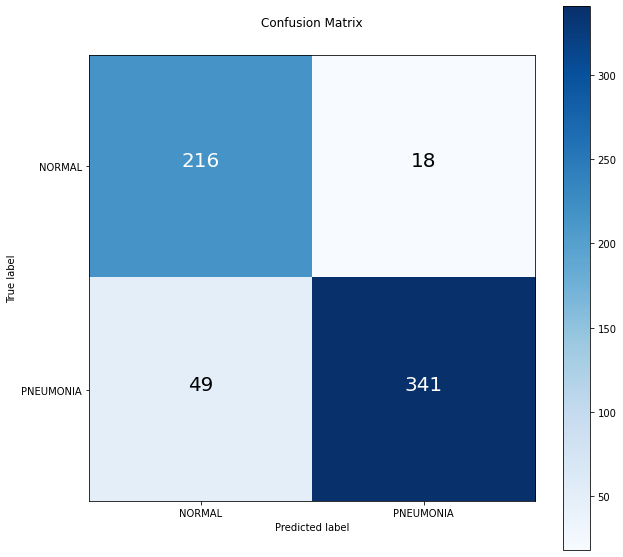

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=y_preds,
                      classes=train_data.class_names,
                      # figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, preds))

              precision    recall  f1-score   support

           0       0.34      0.43      0.38       234
           1       0.59      0.50      0.54       390

    accuracy                           0.47       624
   macro avg       0.47      0.46      0.46       624
weighted avg       0.50      0.47      0.48       624



In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 1)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, None)  0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


### Fine tuning 1

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
                metrics=['accuracy'])

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_1_fine_tune = model_1.fit(train_data,
                                  epochs=fine_tune_epochs,
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                  initial_epoch=history_1.epoch[-1]) # start from previous last epoch

Epoch 5/10
164/164 [==============================] - 54s 295ms/step - loss: 0.1387 - accuracy: 0.9494 - val_loss: 0.2408 - val_accuracy: 0.9271
Epoch 6/10
164/164 [==============================] - 48s 289ms/step - loss: 0.1426 - accuracy: 0.9423 - val_loss: 0.3477 - val_accuracy: 0.8438
Epoch 7/10
164/164 [==============================] - 46s 272ms/step - loss: 0.1348 - accuracy: 0.9467 - val_loss: 0.2552 - val_accuracy: 0.9167
Epoch 8/10
164/164 [==============================] - 46s 275ms/step - loss: 0.1392 - accuracy: 0.9457 - val_loss: 0.2862 - val_accuracy: 0.8958
Epoch 9/10
164/164 [==============================] - 46s 272ms/step - loss: 0.1367 - accuracy: 0.9480 - val_loss: 0.3023 - val_accuracy: 0.8750
Epoch 10/10
164/164 [==============================] - 44s 265ms/step - loss: 0.1367 - accuracy: 0.9472 - val_loss: 0.2823 - val_accuracy: 0.8854


In [ ]:
model_1.evaluate(test_data)

20/20 [==============================] - 4s 133ms/step - loss: 0.2886 - accuracy: 0.8926


[0.28863465785980225, 0.8926281929016113]

Image before conv = (224, 224, 1)
Image after conv = (224, 224, 3)
Prediction is [0.9884814  0.01151862]


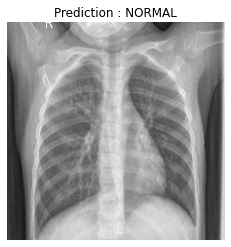

In [ ]:
pred_and_plot(model_1, "/content/norm4.jpeg")

In [ ]:
preds_2 = model_1.predict(test_data)
preds_2 = preds_2.argmax(axis=1)
preds_2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels_2 = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels_2.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels_2[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, preds)
sklearn_accuracy

0.8926282051282052

In [ ]:
y_labels_2 = tf.expand_dims(y_labels_2, axis=1)
y_preds_2 = tf.expand_dims(preds_2, axis=1)

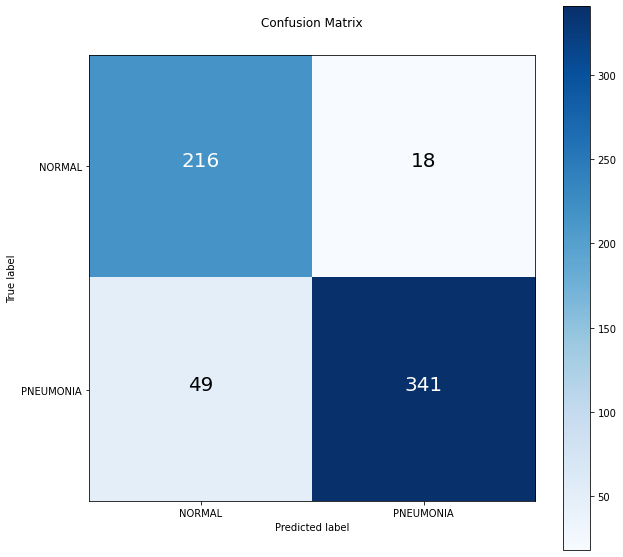

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels_2,
                      y_pred=y_preds_2,
                      classes=train_data.class_names,
                      # figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Model 3

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(2, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_3 = keras.Model(inputs, outputs)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25* len(test_data)))

Epoch 1/5
164/164 [==============================] - 49s 264ms/step - loss: 0.3116 - accuracy: 0.8656 - val_loss: 0.3745 - val_accuracy: 0.8750
Epoch 2/5
164/164 [==============================] - 44s 263ms/step - loss: 0.1925 - accuracy: 0.9262 - val_loss: 0.3135 - val_accuracy: 0.8875
Epoch 3/5
164/164 [==============================] - 42s 252ms/step - loss: 0.1675 - accuracy: 0.9362 - val_loss: 0.3243 - val_accuracy: 0.8687
Epoch 4/5
164/164 [==============================] - 42s 253ms/step - loss: 0.1554 - accuracy: 0.9406 - val_loss: 0.3008 - val_accuracy: 0.8687
Epoch 5/5
164/164 [==============================] - 41s 245ms/step - loss: 0.1460 - accuracy: 0.9469 - val_loss: 0.2896 - val_accuracy: 0.8813


In [ ]:
model_3.evaluate(test_data)

20/20 [==============================] - 4s 138ms/step - loss: 0.3360 - accuracy: 0.8622


[0.33595943450927734, 0.8621794581413269]

### Fine tuning 3 

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
                metrics=['accuracy'])

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_3_fine_tune = model_3.fit(train_data,
                                  epochs=fine_tune_epochs,
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                  initial_epoch=history_3.epoch[-1]) # start from previous last epoch

Epoch 5/10
164/164 [==============================] - 44s 237ms/step - loss: 0.0860 - accuracy: 0.9656 - val_loss: 0.2754 - val_accuracy: 0.8438
Epoch 6/10
164/164 [==============================] - 38s 226ms/step - loss: 0.0772 - accuracy: 0.9698 - val_loss: 0.2578 - val_accuracy: 0.8646
Epoch 7/10
164/164 [==============================] - 39s 229ms/step - loss: 0.0781 - accuracy: 0.9696 - val_loss: 0.2325 - val_accuracy: 0.8854
Epoch 8/10
164/164 [==============================] - 38s 227ms/step - loss: 0.0773 - accuracy: 0.9690 - val_loss: 0.3304 - val_accuracy: 0.8958
Epoch 9/10
164/164 [==============================] - 38s 225ms/step - loss: 0.0703 - accuracy: 0.9734 - val_loss: 0.2473 - val_accuracy: 0.8854
Epoch 10/10
164/164 [==============================] - 38s 227ms/step - loss: 0.0657 - accuracy: 0.9755 - val_loss: 0.2255 - val_accuracy: 0.8958


In [ ]:
model_3.evaluate(test_data)

20/20 [==============================] - 4s 132ms/step - loss: 0.2884 - accuracy: 0.8766


[0.2883562445640564, 0.8766025900840759]

In [ ]:
preds_3 = model_3.predict(test_data)
preds_3 = preds_3.argmax(axis=1)
preds_3

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels_3 = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels_3.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels_3[:10] # check what they look like (unshuffled)

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, preds)
sklearn_accuracy

0.47435897435897434

In [ ]:
y_labels_3 = tf.expand_dims(y_labels_3, axis=1)
y_preds_3 = tf.expand_dims(preds_3, axis=1)

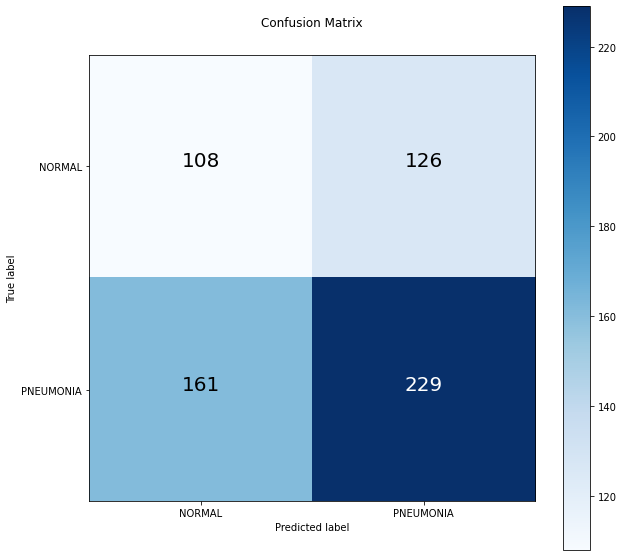

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels_3,
                      y_pred=y_preds_3,
                      classes=train_data.class_names,
                      # figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
boole = preds_3 == y_labels_3
boole

<tf.Tensor: shape=(624, 624), dtype=bool, numpy=
array([[ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       ...,
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True]])>

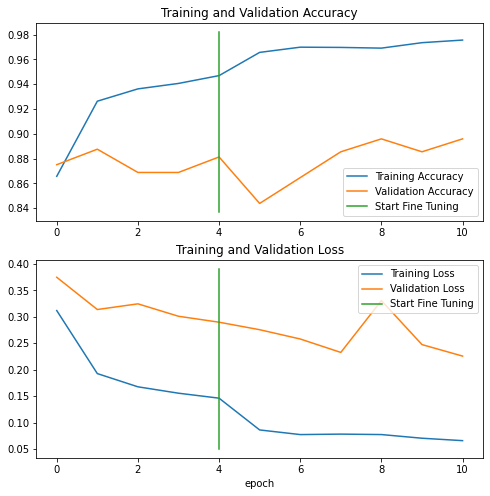

In [ ]:
compare_historys(original_history=history_3, 
                 new_history=history_3_fine_tune, 
                 initial_epochs=5)

In [ ]:
model_3.save("/content/drive/MyDrive/Final-Model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final-Model/assets


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-30]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-6), # 10x lower learning rate than default
                metrics=['accuracy'])

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_3_fine_tune_2 = model_3.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                    initial_epoch=history_3.epoch[-1]) # start from previous last epoch

Epoch 5/10
164/164 [==============================] - 49s 256ms/step - loss: 0.0661 - accuracy: 0.9765 - val_loss: 0.2768 - val_accuracy: 0.8438
Epoch 6/10
164/164 [==============================] - 41s 241ms/step - loss: 0.0609 - accuracy: 0.9765 - val_loss: 0.3793 - val_accuracy: 0.8021
Epoch 7/10
164/164 [==============================] - 40s 240ms/step - loss: 0.0620 - accuracy: 0.9771 - val_loss: 0.2624 - val_accuracy: 0.8750
Epoch 8/10
164/164 [==============================] - 40s 236ms/step - loss: 0.0602 - accuracy: 0.9759 - val_loss: 0.3087 - val_accuracy: 0.8438
Epoch 9/10
164/164 [==============================] - 39s 234ms/step - loss: 0.0606 - accuracy: 0.9774 - val_loss: 0.2927 - val_accuracy: 0.8750
Epoch 10/10
164/164 [==============================] - 39s 231ms/step - loss: 0.0578 - accuracy: 0.9809 - val_loss: 0.2550 - val_accuracy: 0.8646


In [ ]:
model_3.evaluate(test_data)

20/20 [==============================] - 4s 174ms/step - loss: 0.2821 - accuracy: 0.8750


[0.2821185886859894, 0.875]

In [ ]:
preds_4 = model_3.predict(test_data)
preds_4 = preds_4.argmax(axis=1)
preds_4

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels_4 = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels_4.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels_4[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, preds)
sklearn_accuracy

0.8926282051282052

In [ ]:
y_labels_4 = tf.expand_dims(y_labels_4, axis=1)
y_preds_4 = tf.expand_dims(preds_4, axis=1)

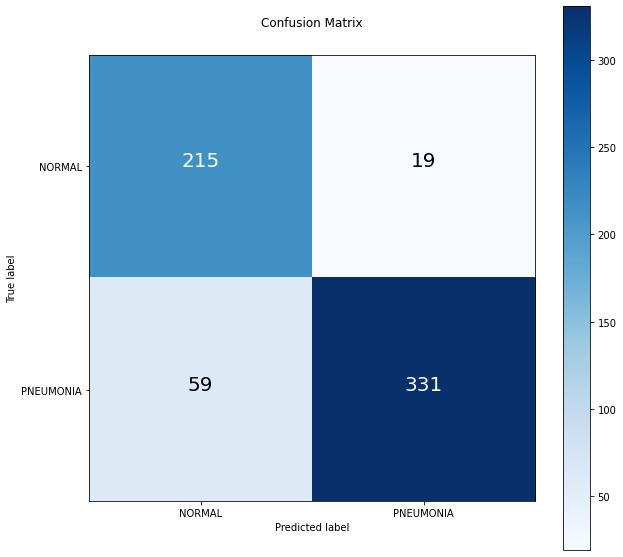

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels_4,
                      y_pred=y_preds_4,
                      classes=train_data.class_names,
                      # figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
Xray_model = tf.keras.models.load_model("/content/drive/MyDrive/Final-Model")

In [ ]:
Xray_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, None)  0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 784,002
Non-trainable params: 3,268,131
_________________________________________________________________


Image shape = (224, 224, 3)
Prediction is [0.15503737 0.8449626 ]


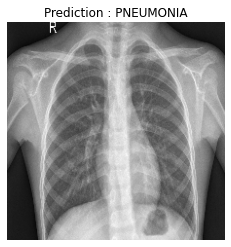

In [ ]:
pred_and_plot(Xray_model, "/content/fixNorm1.jpeg")

In [ ]:
preds_5 = Xray_model.predict(test_data)

In [ ]:
preds_5 = preds_5.argmax(axis=1)
preds_5

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels_5 = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels_5.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels_5[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels_5, preds_5)
sklearn_accuracy

0.8766025641025641

In [ ]:
y_labels_5 = tf.expand_dims(y_labels_5, axis=1)
y_preds_5 = tf.expand_dims(preds_5, axis=1)

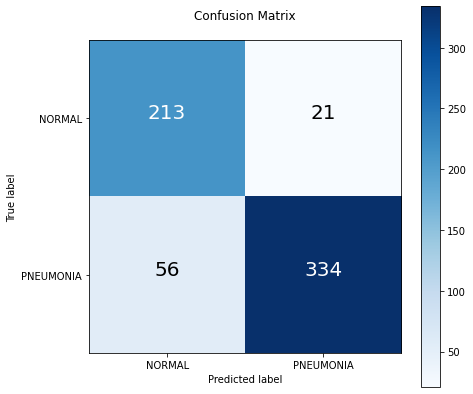

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels_5,
                      y_pred=y_preds_5,
                      classes=train_data.class_names,
                      figsize=(7, 7),
                      text_size=20,
                      norm=False,
                      savefig=True)

Image before conv = [[[18.        ]
  [20.368624  ]
  [26.713009  ]
  ...
  [ 7.3571777 ]
  [ 2.011745  ]
  [ 0.07141113]]

 [[18.042091  ]
  [23.589287  ]
  [27.        ]
  ...
  [ 8.357178  ]
  [ 4.8916802 ]
  [ 0.1134927 ]]

 [[21.999998  ]
  [24.438776  ]
  [24.410717  ]
  ...
  [ 9.707977  ]
  [ 6.2105274 ]
  [ 1.0714111 ]]

 ...

 [[10.        ]
  [10.        ]
  [ 8.035645  ]
  ...
  [15.        ]
  [15.        ]
  [15.        ]]

 [[10.        ]
  [10.        ]
  [10.        ]
  ...
  [15.        ]
  [15.        ]
  [15.        ]]

 [[10.        ]
  [10.        ]
  [10.        ]
  ...
  [15.        ]
  [15.        ]
  [15.        ]]]
Image after conv = [[[18.         18.         18.        ]
  [20.368624   20.368624   20.368624  ]
  [26.713009   26.713009   26.713009  ]
  ...
  [ 7.3571777   7.3571777   7.3571777 ]
  [ 2.011745    2.011745    2.011745  ]
  [ 0.07141113  0.07141113  0.07141113]]

 [[18.042091   18.042091   18.042091  ]
  [23.589287   23.589287   23.589287  ]
  [

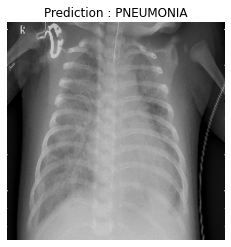

In [ ]:
pred_and_plot(Xray_model, "/content/pneu3.jpeg")

In [ ]:
pred = Xray_model.predict(test_data)

In [ ]:
len(pred)

624

In [ ]:
test_data1 = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMAGE_SHAPE,
                                                                 label_mode="categorical",
                                                                 batch_size=1,
                                                                 shuffle=False)

Found 624 files belonging to 2 classes.


In [ ]:
test_data1

<BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [ ]:
len(test_data)

20

In [ ]:
pred[:10]

array([[0.9857341 , 0.01426593],
       [0.9951245 , 0.00487553],
       [0.96321946, 0.03678057],
       [0.993814  , 0.00618604],
       [0.9625171 , 0.03748292],
       [0.99548894, 0.00451101],
       [0.979702  , 0.02029802],
       [0.8526296 , 0.14737038],
       [0.89078444, 0.1092155 ],
       [0.99825686, 0.00174318]], dtype=float32)

In [ ]:
# function to import image and resize 
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape,, color_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image  
  img = tf.image.resize(img, size=IMAGE_SHAPE)
  #Grayscale
  print(f"Image before conv = {img.shape}")
  if img.shape[2] == 1:
    img = tf.image.grayscale_to_rgb(img)
    print(f"Image after conv = {img.shape}")
  # Rescale the image (getting all values between 0 & 1)
  # img = img/255

  return img

In [ ]:
def pred_and_plot(model, filename, class_names=["NORMAL","PNEUMONIA"]):
  """
  Imports an image located at filename, makes a prediction with model and plots the image with the predicted class as the title.
  """
  # Import target image and preprocess it 
  img = load_and_prep_image(filename)

  # Make a prediction 
  pred = model.predict(tf.expand_dims(img, axis=0))
  # pred = model.predict(tf.squeeze(img))
  print(f"Prediction is {tf.squeeze(pred).numpy()}")
  # print(f"Prediction is {pred}")

  # Get the predicted class 
  # pred_class = class_names[int(tf.round(pred))]
  pred_class = class_names[int(tf.argmax(tf.squeeze(pred).numpy()))]

  # Plot image and predicted class
  img = img/255
  plt.imshow(img)
  plt.title(f"Prediction : {pred_class}")
  plt.axis(False);

Image before conv = (224, 224, 1)
Image after conv = (224, 224, 3)
Prediction is [0.1099832  0.89001685]


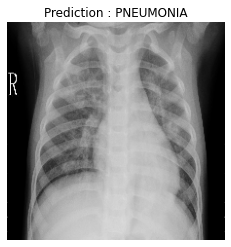

In [ ]:
pred_and_plot(Xray_model, "/content/pneu4.jpeg")